In [1]:
import numpy as np
import scipy.stats
import tensorflow as tf
import matplotlib.pyplot as plt

from normalizing_flow import *

In [2]:
lim = [-7, 7]

np.random.seed(85)

graph = tf.Graph()
with graph.as_default():
    fvar = FlowRandomVariable(dim=2, num_layers=1)
    samples, prob = fvar.sample_log_prob(100000)
    prob = tf.exp(prob)
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        trans, dens = sess.run([samples, prob])

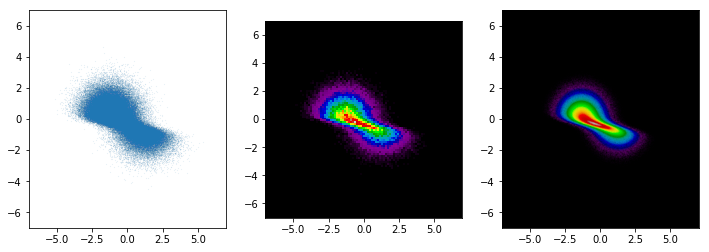

In [3]:
fig, ax = plt.subplots(1, 3)
ax[0].scatter(trans[:, 0], trans[:, 1], s=0.001)
ax[0].set_xlim(lim[0], lim[1])
ax[0].set_ylim(lim[0], lim[1])
hist = np.histogram2d(trans[:, 0], trans[:, 1], bins=100, range=[lim, lim])[0]
ax[1].imshow(np.fliplr(hist).T,
             cmap='nipy_spectral', extent=[lim[0], lim[1], lim[0], lim[1]])
ax[2].set_facecolor('0')
ax[2].scatter(trans[:, 0], trans[:, 1], c=dens, s=0.001, cmap='nipy_spectral')
ax[2].set_xlim(lim[0], lim[1])
ax[2].set_ylim(lim[0], lim[1])
fig.set_size_inches(12, 4)
plt.show()

# Broadcasting Flows

In [4]:
with tf.Graph().as_default():
    u = tf.constant(np.array([[1., 1.], [1., 1.]]))
    w = tf.constant(np.array([[1., 1.], [4., 4.]]))
    b = tf.constant(np.array([0., 0.]))
    
    x = tf.constant(np.random.normal(0, 1, [2, 10000, 2]))
    flow = PlanarFlow(dim=2, u=u, w=w, b=b)
    y = flow.transform(x)
    z = flow.log_det_jacobian(x)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        y_, z_ = sess.run([y, z])

In [5]:
print y_.shape, z_.shape

(2, 10000, 2) (2, 10000)


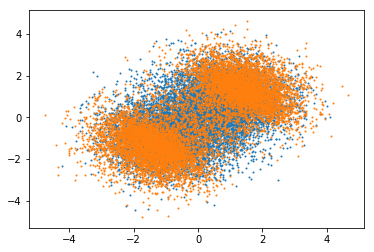

In [6]:
plt.scatter(y_[0, :, 0], y_[0, :, 1], s=1)
plt.scatter(y_[1, :, 0], y_[1, :, 1], s=1)

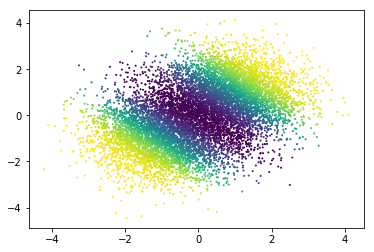

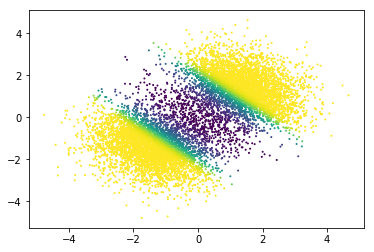

In [7]:
plt.scatter(y_[0, :, 0], y_[0, :, 1], c=z_[0, :], s=1)
plt.show()
plt.scatter(y_[1, :, 0], y_[1, :, 1], c=z_[1, :], s=1)
plt.show()

# Broad Casting Flow Random Variable

In [8]:
with tf.Graph().as_default():
    w = tf.constant(np.array([[1., 1.], [1., 1.]]))
    u = tf.constant(np.array([[1., 1.], [1., 1.]]))
    b = tf.constant(np.array([1., 0.]))
    flow = PlanarFlow(dim=2, w=w, b=b, u=u)
    var = FlowRandomVariable(dim=2, flows=[flow],  base_dist=None)
    s, p = var.sample_log_prob(100000)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        s_, p_ = sess.run([s, p])

In [9]:
s_.shape, p_.shape

((2, 100000, 2), (2, 100000))

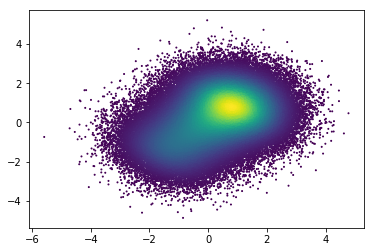

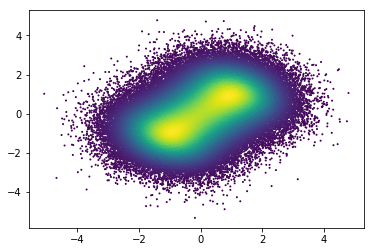

In [10]:
plt.scatter(s_[0, :, 0], s_[0, :, 1], c=np.exp(p_[0, :]), s=1)
plt.show()
plt.scatter(s_[1, :, 0], s_[1, :, 1], c=np.exp(p_[1, :]), s=1)
plt.show()

# Broad Casting Flow Conditional Random Variable

In [11]:
with tf.Graph().as_default():
    y = tf.constant(np.random.normal(0, 1, [2, 100]))
    var = FlowConditionalVariable(dim_x=2, y=y, flow_layers=10, base_dist=None)
    s, p = var.sample_log_prob(10000)
    u, w, b = var.u, var.w, var.b
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        s_, p_, u_, w_, b_ = sess.run([s, p, u, w, b])

In [12]:
print u_
print w_
print b_

[[1.00734646 0.86790237 1.02672466 0.73256154 1.19509688 1.20016163
  1.11397684 0.81077211 0.96391744 1.17369096 1.00892791 0.97056004
  1.14132358 1.14073994 1.00383771 0.93196362 1.13020872 1.06093208
  0.92591469 1.07613542]
 [0.61773201 1.13996929 1.45933038 0.69873726 1.35885668 0.82327181
  1.54006773 1.24434491 1.36271221 1.84680589 1.30163949 1.14609041
  0.92144333 1.57565284 0.42968273 0.43911605 1.35883803 1.29547824
  0.69972899 1.03208657]]
[[ 0.79087039  1.30025409  1.32280727  0.95901603  0.3839838   1.72795969
   0.49598307  1.87869718  0.90181488  0.4720359   1.68644444  1.10549237
   1.33876729  0.30999176  1.08388507  0.89844409  1.81120089  1.6119882
   1.16330693  1.45742066]
 [ 0.33658669  1.44147833  1.14742092  1.00004463 -0.50332442  1.67482215
   0.12363009  2.29335682  0.61030141 -0.41324801  1.77344855  1.77968455
   1.50336912 -0.65583211  0.69097661  0.96768624  2.76265333  2.25954153
   1.30795849  2.48417597]]
[[-0.44926217 -0.76950866  0.42108013 -0.53

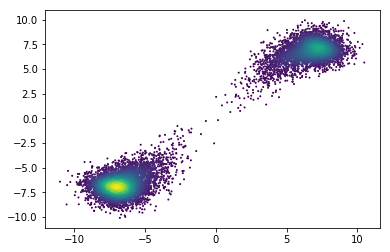

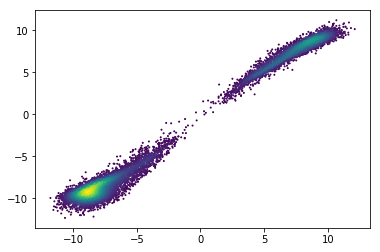

In [13]:
plt.scatter(s_[0, :, 0], s_[0, :, 1], c=np.exp(p_[0, :]), s=1)
plt.show()
plt.scatter(s_[1, :, 0], s_[1, :, 1], c=np.exp(p_[1, :]), s=1)
plt.show()

# Dynamical Flow

In [7]:
np.random.seed(11)

TIME = 10
DIM = 2

graph = tf.Graph()
with graph.as_default():
    fvar = FlowRandomVariable(dim=TIME * DIM, num_layers=20)
    f_samples, f_prob = fvar.sample_log_prob(100)
    f_prob = tf.exp(f_prob)
    # Dynamical flow.
    dvar = DynaFlowRandomVariable(dim=DIM, time=TIME, num_layers=10)
    d_samples, d_prob = dvar.sample_log_prob(100)
    d_prob = tf.exp(d_prob)
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        f_trans, f_dens = sess.run([f_samples, f_prob])
        d_trans, d_dens = sess.run([d_samples, d_prob])

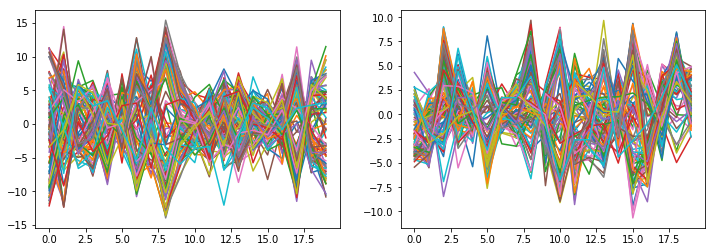

In [8]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(f_trans.T)
ax[1].plot(d_trans.T)
fig.set_size_inches(12, 4)
plt.show()

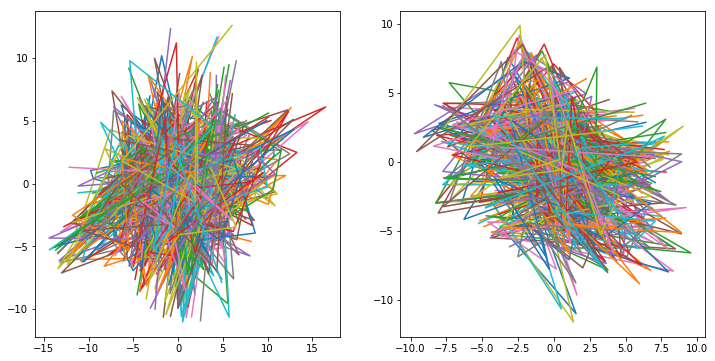

In [20]:
fig, ax = plt.subplots(1, 2)
def plot_dynamics(ax, samples):
    n_samples = samples.shape[0]
    time = samples.shape[1]
    x_idx = np.arange(0, time, 2)
    y_idx = np.arange(1, time, 2)
    time = time // 2
    
    for i in range(100):
        x = samples[i, x_idx]
        y = samples[i, y_idx]
        ax.plot(x, y)

plot_dynamics(ax[0], f_trans)
plot_dynamics(ax[1], d_trans)
fig.set_size_inches(12, 6)
plt.show()